In [1]:
# Make sure base libs are there
%pip install -q torch torchvision pillow opencv-python matplotlib

# Install the exact versions that work together
%pip install -q supervision==0.6.0
%pip install -q groundingdino-py==0.4.0 --no-deps   # prevents pip from changing supervision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import groundingdino, supervision
print("GroundingDINO:", groundingdino.__file__)
print("supervision version:", supervision.__version__)


GroundingDINO: /usr/local/lib/python3.12/dist-packages/groundingdino/__init__.py
supervision version: 0.6.0


In [3]:
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py -O GroundingDINO_SwinT_OGC.py
!wget -q https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth -O groundingdino_swint_ogc.pth


In [5]:
%pip install -q addict==2.4.0 yapf==0.43.0 supervision==0.6.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 9.1 MB/s eta 0:00:00


In [6]:
from groundingdino.util.inference import load_model, load_image, predict, annotate


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:
import os, torch, cv2, matplotlib.pyplot as plt
from groundingdino.util.inference import load_model, load_image, predict, annotate

# Use CPU (no GPU in your runtime)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
config_path  = "./GroundingDINO_SwinT_OGC.py"
weights_path = "./groundingdino_swint_ogc.pth"

model = load_model(config_path, weights_path, device="cpu")
print("Model ready on CPU.")


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model ready on CPU.


In [12]:
from google.colab import files
uploaded = files.upload()  # click “Choose files” and pick your image

# Get the uploaded filename
if not uploaded:
    raise SystemExit("No file selected.")
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)


Saving cat.jpg.webp to cat.jpg.webp
Uploaded: cat.jpg.webp


In [14]:
from PIL import Image
if image_path.lower().endswith(".webp"):
    Image.open(image_path).convert("RGB").save("converted.jpg", "JPEG")
    image_path = "converted.jpg"
print("Final image_path:", image_path)


Final image_path: converted.jpg


(np.float64(-0.5), np.float64(1599.5), np.float64(1053.5), np.float64(-0.5))

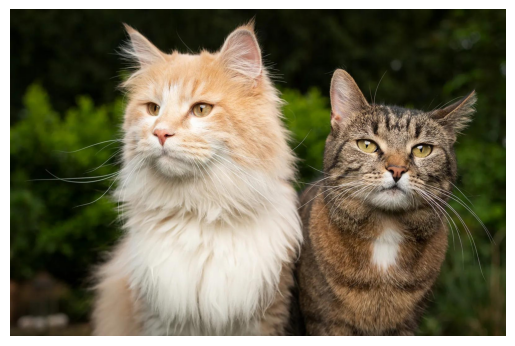

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(image_path)
plt.imshow(img); plt.axis("off")


In [16]:
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py -O GroundingDINO_SwinT_OGC.py
!wget -q https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth -O groundingdino_swint_ogc.pth
print("Config & weights ready.")


Config & weights ready.


In [17]:
import os, torch
from groundingdino.util.inference import load_model

os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU
model = load_model("./GroundingDINO_SwinT_OGC.py", "./groundingdino_swint_ogc.pth", device="cpu")
print("Model loaded on CPU.")


final text_encoder_type: bert-base-uncased
Model loaded on CPU.


In [18]:
from PIL import Image
import os

# Use the variable from your upload step:
# image_path already exists from your previous cell
assert os.path.exists(image_path), f"Not found: {image_path}"

img = Image.open(image_path).convert("RGB")
max_side = 1024  # make 768 if you want it even faster
if max(img.size) > max_side:
    scale = max(img.size) / max_side
    img = img.resize((int(img.width/scale), int(img.height/scale)))
    img.save("resized.jpg", "JPEG", quality=92)
    image_path = "resized.jpg"
print("Using:", image_path)


Using: resized.jpg


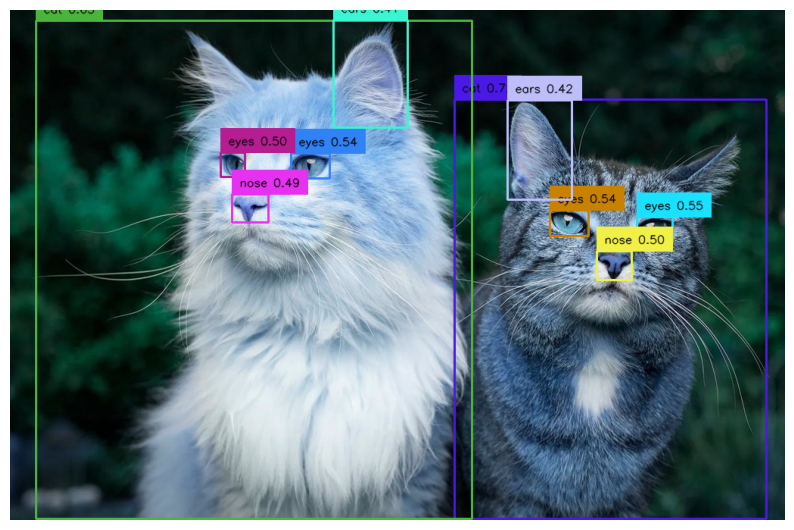

Saved: detected.jpg


In [22]:
import matplotlib.pyplot as plt
import cv2
from groundingdino.util.inference import load_image, predict, annotate

# Load image
image_source, image = load_image(image_path)

# Your text "shopping list" (edit freely)
TEXT_PROMPT    = "cat . eyes . ears . nose"
BOX_THRESHOLD  = 0.40   # higher = fewer, cleaner boxes
TEXT_THRESHOLD = 0.28   # higher = stricter text match

with torch.inference_mode():
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        device="cpu"
    )

annotated = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# Show
plt.figure(figsize=(10,8))
plt.imshow(annotated)
plt.axis("off")
plt.show()

# Save
cv2.imwrite("detected.jpg", annotated[..., ::-1])
print("Saved: detected.jpg")


In [20]:
more_prompts = [
    "kitten . paw . tail . collar",
    "nose . whiskers . eyes"
]
for i, p in enumerate(more_prompts, 1):
    with torch.inference_mode():
        b,l,ph = predict(model=model, image=image, caption=p,
                         box_threshold=0.40, text_threshold=0.28, device="cpu")
    ann = annotate(image_source=image_source, boxes=b, logits=l, phrases=ph)
    cv2.imwrite(f"detected_{i}.jpg", ann[..., ::-1])
print("Saved: detected_1.jpg, detected_2.jpg")


Saved: detected_1.jpg, detected_2.jpg


In [21]:
from google.colab import files
files.download("detected.jpg")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>